## Membership inference on text
### Stanford Sentiment Treebank (SST) movie review dataset for sentiment analysis

In [1]:
import torch

from torchtext import data
from torchtext import datasets 
import sys
import seaborn as sns
from sklearn.metrics import roc_curve, auc

sys.path.insert(0, '../../../Utils/')

import matplotlib.pyplot as plt
%matplotlib inline  

import models
from train import *
from metrics import * 

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0]
Pytorch: 1.0.0


### Load SST using Torchtext

In [2]:
# To fix the following error: OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.
# Run: 
# python -m spacy download en


TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(tensor_type=torch.LongTensor)

target, val, shadow = datasets.SST.splits(TEXT, LABEL, root='../../../Datasets/SST_data', fine_grained=True)

target_in, target_out = target.split(split_ratio=0.5)
shadow_in, shadow_out = shadow.split(split_ratio=0.5)

TEXT.build_vocab(target, max_size=25000, vectors="glove.6B.100d", vectors_cache='../../../Datasets/SST_data/vector_cache')
LABEL.build_vocab(target)

BATCH_SIZE = 32

shadow_in_itr, shadow_out_itr, target_in_itr, target_out_itr, val_itr = data.BucketIterator.splits(
    (shadow_in, shadow_out, target_in, target_out, val), 
    batch_size = BATCH_SIZE, 
    sort_key= lambda x: len(x.text), 
    repeat=False
)

### Create bidirectional LSTM model for sentiment analysis

In [3]:
vocab_size = len(TEXT.vocab)
embedding_size = 100
hidden_size = 256
output_size = 5


target_model = models.RNN(vocab_size, embedding_size, hidden_size, output_size)
shadow_model = models.RNN(vocab_size, embedding_size, hidden_size, output_size)

pretrained_embeddings = TEXT.vocab.vectors
target_model.embedding.weight.data.copy_(pretrained_embeddings)
shadow_model.embedding.weight.data.copy_(pretrained_embeddings)
print("")

target_optimizer = torch.optim.Adam(target_model.parameters())
shadow_optimizer = torch.optim.Adam(shadow_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

target_model = target_model.to(device)
shadow_model = shadow_model.to(device)
criterion = criterion.to(device)

### Utility functions

In [4]:
def classification_accuracy(preds, y):

    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

def binary_accuracy(preds, y):

    rounded_preds = torch.round(preds)

    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

### Evaluation functions

In [5]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = classification_accuracy(predictions.argmax(dim=1), batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_inference(target_model, attack_model, in_iterator, out_iterator, criterion, k):
    
    epoch_loss = 0
    epoch_acc = 0
    
    shadow_model.eval()
    attack_model.eval()
    
    predictions = np.array([])
    labels = np.array([])
    
    with torch.no_grad():
    
        for in_batch, out_batch in zip(in_iterator, out_iterator):

            in_size = len(in_batch.label)
            out_size = len(out_batch.label)
            in_lbl = torch.ones(in_size).to(device)
            out_lbl = torch.zeros(out_size).to(device)
            
            
            in_predictions = torch.nn.functional.softmax(target_model(in_batch.text.detach()), dim=1).detach()
            out_predictions = torch.nn.functional.softmax(target_model(out_batch.text.detach()), dim=1).detach()
            
            in_sort, _ = torch.sort(in_predictions, descending=True)
            in_top_k = in_sort[:,:k].clone().to(device)

            out_sort, _ = torch.sort(out_predictions, descending=True)
            out_top_k = out_sort[:,:k].clone().to(device)
            
            
            in_inference = attack_model(in_top_k).squeeze(1)
            out_inference = attack_model(out_top_k).squeeze(1)
            
            in_probability = torch.nn.functional.sigmoid(in_inference).detach().cpu().numpy()
            out_probability = torch.nn.functional.sigmoid(out_inference).detach().cpu().numpy()
        
            loss = (criterion(in_inference, in_lbl) + criterion(out_inference, out_lbl)) / 2
            acc = (binary_accuracy(in_inference, in_lbl) + binary_accuracy(out_inference, out_lbl)) / 2
            
            predictions = np.concatenate((predictions, in_probability), axis=0)
            labels = np.concatenate((labels, np.ones(in_size)), axis=0)
            predictions = np.concatenate((predictions, out_probability), axis=0)
            labels = np.concatenate((labels, np.zeros(out_size)), axis=0)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    return epoch_loss / len(in_iterator), epoch_acc / len(in_iterator), fpr, tpr, roc_auc

### Train functions

In [6]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)

        acc = classification_accuracy(predictions.argmax(dim=1), batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def train_nlp_attack(shadow_model, attack_model, in_iterator, out_iterator, optimizer, criterion, k):
    
    epoch_loss = 0
    epoch_acc = 0
    
    shadow_model.eval()
    attack_model.train()
    
    in_input = np.empty((0,2))
    out_input = np.empty((0,2))
    
    for in_batch, out_batch in zip(in_iterator, out_iterator):

        optimizer.zero_grad()
        
        in_predictions = torch.nn.functional.softmax(shadow_model(in_batch.text.detach()), dim=1).detach()
        out_predictions = torch.nn.functional.softmax(shadow_model(out_batch.text.detach()), dim=1).detach()

        in_lbl = torch.ones(len(in_batch.label)).to(device)
        out_lbl = torch.zeros(len(out_batch.label)).to(device)
        
        in_sort, _ = torch.sort(in_predictions, descending=True)
        in_top_k = in_sort[:,:k].clone().to(device)

        out_sort, _ = torch.sort(out_predictions, descending=True)
        out_top_k = out_sort[:,:k].clone().to(device)

        in_inference = attack_model(in_top_k).squeeze(1)
        out_inference = attack_model(out_top_k).squeeze(1)
        
        in_input = np.vstack((in_input, torch.cat((torch.max(in_predictions, dim=1, keepdim=True)[0], in_batch.label.view(-1,1).type(torch.cuda.FloatTensor)), dim=1).cpu().numpy() ))
        out_input = np.vstack((out_input, torch.cat((torch.max(out_predictions, dim=1, keepdim=True)[0], out_batch.label.view(-1,1).type(torch.cuda.FloatTensor)), dim=1).cpu().numpy() ))
     
        loss = (criterion(in_inference, in_lbl) + criterion(out_inference, out_lbl)) / 2
        acc = (binary_accuracy(in_inference, in_lbl) + binary_accuracy(out_inference, out_lbl)) / 2

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
            
    return epoch_loss / len(in_iterator), epoch_acc / len(in_iterator), in_input, out_input

### Train target model

In [7]:
n_epochs_classification = 30

for epoch in range(n_epochs_classification):

    train_loss, train_acc = train(target_model, target_in_itr, target_optimizer, criterion)
    valid_loss, valid_acc = evaluate(target_model, val_itr, criterion)
    
    print('Epoch: %02d, Train Loss: %.3f, Train Acc: %.2f%%, Val. Loss: %.3f, Val. Acc: %.2f%%' % (epoch+1, train_loss, train_acc*100, valid_loss, valid_acc*100))

/home/ljt/cyphercat/venv/lib/python3.7/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Epoch: 01, Train Loss: 1.534, Train Acc: 31.37%, Val. Loss: 1.494, Val. Acc: 29.00%
Epoch: 02, Train Loss: 1.428, Train Acc: 36.94%, Val. Loss: 1.358, Val. Acc: 39.76%
Epoch: 03, Train Loss: 1.320, Train Acc: 42.89%, Val. Loss: 1.346, Val. Acc: 40.12%
Epoch: 04, Train Loss: 1.227, Train Acc: 46.99%, Val. Loss: 1.411, Val. Acc: 40.08%
Epoch: 05, Train Loss: 1.132, Train Acc: 50.07%, Val. Loss: 1.420, Val. Acc: 41.05%
Epoch: 06, Train Loss: 1.034, Train Acc: 55.13%, Val. Loss: 1.440, Val. Acc: 40.20%
Epoch: 07, Train Loss: 0.916, Train Acc: 61.05%, Val. Loss: 1.526, Val. Acc: 42.53%
Epoch: 08, Train Loss: 0.801, Train Acc: 67.23%, Val. Loss: 1.693, Val. Acc: 40.83%
Epoch: 09, Train Loss: 0.714, Train Acc: 71.64%, Val. Loss: 1.942, Val. Acc: 37.84%
Epoch: 10, Train Loss: 0.619, Train Acc: 76.31%, Val. Loss: 2.082, Val. Acc: 37.26%
Epoch: 11, Train Loss: 0.557, Train Acc: 77.94%, Val. Loss: 2.376, Val. Acc: 38.37%
Epoch: 12, Train Loss: 0.485, Train Acc: 81.09%, Val. Loss: 2.239, Val. Acc:

### Train shadow model

In [8]:
for epoch in range(n_epochs_classification):

    train_loss, train_acc = train(shadow_model, shadow_in_itr, shadow_optimizer, criterion)
    valid_loss, valid_acc = evaluate(shadow_model, val_itr, criterion)
    
    print('Epoch: %02d, Train Loss: %.3f, Train Acc: %.2f%%, Val. Loss: %.3f, Val. Acc: %.2f%%' % (epoch+1, train_loss, train_acc*100, valid_loss, valid_acc*100))


Epoch: 01, Train Loss: 1.583, Train Acc: 25.24%, Val. Loss: 1.581, Val. Acc: 29.59%
Epoch: 02, Train Loss: 1.535, Train Acc: 31.43%, Val. Loss: 1.527, Val. Acc: 34.46%
Epoch: 03, Train Loss: 1.516, Train Acc: 32.16%, Val. Loss: 1.524, Val. Acc: 30.57%
Epoch: 04, Train Loss: 1.443, Train Acc: 38.14%, Val. Loss: 1.444, Val. Acc: 36.02%
Epoch: 05, Train Loss: 1.389, Train Acc: 41.27%, Val. Loss: 1.427, Val. Acc: 36.68%
Epoch: 06, Train Loss: 1.325, Train Acc: 43.11%, Val. Loss: 1.422, Val. Acc: 34.77%
Epoch: 07, Train Loss: 1.264, Train Acc: 45.48%, Val. Loss: 1.404, Val. Acc: 37.04%
Epoch: 08, Train Loss: 1.210, Train Acc: 50.19%, Val. Loss: 1.474, Val. Acc: 35.79%
Epoch: 09, Train Loss: 1.113, Train Acc: 51.00%, Val. Loss: 1.475, Val. Acc: 34.85%
Epoch: 10, Train Loss: 1.027, Train Acc: 58.37%, Val. Loss: 1.677, Val. Acc: 35.08%
Epoch: 11, Train Loss: 0.961, Train Acc: 60.06%, Val. Loss: 1.499, Val. Acc: 35.70%
Epoch: 12, Train Loss: 0.849, Train Acc: 66.19%, Val. Loss: 1.735, Val. Acc:

### Evaluate models on test set

In [9]:
target_test_loss, target_test_acc = evaluate(target_model, val_itr, criterion)
shadow_test_loss, shadow_test_acc = evaluate(shadow_model, val_itr, criterion)

print('Target net test accuracy: %.2f , Shadow net test accuracy: %.2f' % (target_test_acc, shadow_test_acc))

Target net test accuracy: 0.37 , Shadow net test accuracy: 0.35


### Create ML-leaks adversary 1 model (multi layer perceptron)

In [10]:
attack_model = models.mlp(3,1,32).to(device)

attack_loss = torch.nn.BCELoss()
attack_optim = torch.optim.Adam(attack_model.parameters(), lr=0.01)

### Train attack model

In [11]:
n_epochs_attack = 30

for epoch in range(n_epochs_attack):

    train_loss, train_acc, in_input, out_input = train_nlp_attack(shadow_model, attack_model, shadow_in_itr, shadow_out_itr, attack_optim, attack_loss, 3)
    valid_loss, valid_acc, fpr, tpr, roc_auc = evaluate_inference(target_model, attack_model, target_in_itr, target_out_itr, attack_loss, 3)

    print('Epoch: %02d, Train Loss: %.3f, Train Acc: %.2f%%, Val. Loss: %.3f, Val. Acc: %.2f%%' % (epoch+1, train_loss, train_acc*100, valid_loss, valid_acc*100))

/home/ljt/cyphercat/venv/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 01, Train Loss: 0.572, Train Acc: 71.05%, Val. Loss: 0.488, Val. Acc: 76.08%
Epoch: 02, Train Loss: 0.501, Train Acc: 77.53%, Val. Loss: 0.480, Val. Acc: 77.65%
Epoch: 03, Train Loss: 0.504, Train Acc: 77.65%, Val. Loss: 0.490, Val. Acc: 78.70%
Epoch: 04, Train Loss: 0.494, Train Acc: 77.71%, Val. Loss: 0.472, Val. Acc: 77.88%
Epoch: 05, Train Loss: 0.487, Train Acc: 78.25%, Val. Loss: 0.467, Val. Acc: 78.70%
Epoch: 06, Train Loss: 0.491, Train Acc: 78.27%, Val. Loss: 0.476, Val. Acc: 78.49%
Epoch: 07, Train Loss: 0.486, Train Acc: 78.20%, Val. Loss: 0.467, Val. Acc: 79.91%
Epoch: 08, Train Loss: 0.489, Train Acc: 78.12%, Val. Loss: 0.466, Val. Acc: 78.52%
Epoch: 09, Train Loss: 0.482, Train Acc: 78.34%, Val. Loss: 0.471, Val. Acc: 78.66%
Epoch: 10, Train Loss: 0.484, Train Acc: 78.38%, Val. Loss: 0.477, Val. Acc: 78.59%
Epoch: 11, Train Loss: 0.482, Train Acc: 78.74%, Val. Loss: 0.469, Val. Acc: 78.85%
Epoch: 12, Train Loss: 0.480, Train Acc: 79.07%, Val. Loss: 0.479, Val. Acc:

### Attack Results

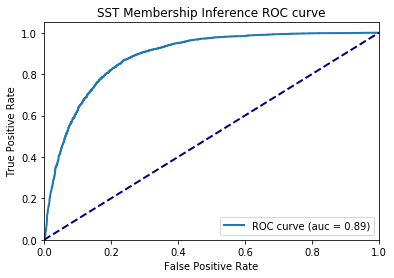

In [12]:
lw = 2
plt.figure()
plt.plot(fpr, tpr, lw=lw, 
         label='ROC curve (auc = %.2f)' % (roc_auc))
plt.plot([0,1],[0,1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.title('SST Membership Inference ROC curve')
plt.legend(loc="lower right")
plt.show()

import pickle
results = (fpr, tpr, roc_auc)
pickle.dump(results, open("sst_results", "wb"))

In [13]:
# in_positive = in_input[in_input[:,1] == 1][:,0]
# in_negative = in_input[in_input[:,1] == 0][:,0]

# out_positive = out_input[out_input[:,1] == 1][:,0]
# out_negative = out_input[out_input[:,1] == 0][:,0]


# plt.figure()
# sns.distplot(in_positive[:100],label='in positive', kde=True, hist=True, norm_hist=True)
# sns.distplot(out_positive[:100],label='out positive', kde=True, hist=True, norm_hist=True)
# plt.legend()
# plt.xlim([0.4, 1.05])
# plt.ylim([0.0, 20])
# plt.title("Positive predictions")
# plt.show()

# plt.figure()
# sns.distplot(in_negative,label='in negative')
# sns.distplot(out_negative,label='out negative')
# plt.legend()
# plt.title("Negative predictions")
# plt.show()
